In [ ]:
!pip install rake-nltk

In [ ]:
import pandas as pd
from rake_nltk import Rake
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('https://query.data.world/s/uikepcpffyo2nhig52xxeevdialfl7')

df = df[['Title','Genre','Director','Actors','Plot']]
df.head()

,Title,Genre,Director,Actors,Plot
0,The Shawshank Redemption,"Crime, Drama",Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...
1,The Godfather,"Crime, Drama",Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Richard ...",The aging patriarch of an organized crime dyna...
2,The Godfather: Part II,"Crime, Drama",Francis Ford Coppola,"Al Pacino, Robert Duvall, Diane Keaton, Robert...",The early life and career of Vito Corleone in ...
3,The Dark Knight,"Action, Crime, Drama",Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",When the menace known as the Joker emerges fro...
4,12 Angry Men,"Crime, Drama",Sidney Lumet,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",A jury holdout attempts to prevent a miscarria...


In [ ]:
df = df[['Title','Genre','Director','Actors','Plot']]
df.head()

,Title,Genre,Director,Actors,Plot
0,The Shawshank Redemption,"Crime, Drama",Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...
1,The Godfather,"Crime, Drama",Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Richard ...",The aging patriarch of an organized crime dyna...
2,The Godfather: Part II,"Crime, Drama",Francis Ford Coppola,"Al Pacino, Robert Duvall, Diane Keaton, Robert...",The early life and career of Vito Corleone in ...
3,The Dark Knight,"Action, Crime, Drama",Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",When the menace known as the Joker emerges fro...
4,12 Angry Men,"Crime, Drama",Sidney Lumet,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",A jury holdout attempts to prevent a miscarria...


In [ ]:
df.shape

(250, 5)

In [ ]:
# discarding the commas between the actors' full names and getting only the first three names
df['Actors'] = df['Actors'].map(lambda x: x.split(',')[:3])

# putting the genres in a list of words
df['Genre'] = df['Genre'].map(lambda x: x.lower().split(','))

df['Director'] = df['Director'].map(lambda x: x.split(' '))

# merging together first and last name for each actor and director, so it's considered as one word 
# and there is no mix up between people sharing a first name
for index, row in df.iterrows():
    row['Actors'] = [x.lower().replace(' ','') for x in row['Actors']]
    row['Director'] = ''.join(row['Director']).lower()

In [ ]:
# initializing the new column
df['Key_words'] = ""

for index, row in df.iterrows():
    plot = row['Plot']
    
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    
    # assigning the key words to the new column
    row['Key_words'] = list(key_words_dict_scores.keys())

# dropping the Plot column
df.drop(columns = ['Plot'], inplace = True)

In [ ]:
df.set_index('Title', inplace = True)
df.head()

,Genre,Director,Actors,Key_words
Title,,,,
The Shawshank Redemption,"[crime, drama]",frankdarabont,"[timrobbins, morganfreeman, bobgunton]","[two, imprisoned, men, bond, eventual, redempt..."
The Godfather,"[crime, drama]",francisfordcoppola,"[marlonbrando, alpacino, jamescaan]","[aging, patriarch, organized, crime, dynasty, ..."
The Godfather: Part II,"[crime, drama]",francisfordcoppola,"[alpacino, robertduvall, dianekeaton]","[tightens, early, life, career, vito, corleone..."
The Dark Knight,"[action, crime, drama]",christophernolan,"[christianbale, heathledger, aaroneckhart]","[dark, knight, must, accept, one, fight, injus..."
12 Angry Men,"[crime, drama]",sidneylumet,"[martinbalsam, johnfiedler, leej.cobb]","[miscarriage, prevent, justice, jury, holdout,..."


In [ ]:
df['bag_of_words'] = ''
columns = df.columns
for index, row in df.iterrows():
    words = ''
    for col in columns:
        if col != 'Director':
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    row['bag_of_words'] = words
    
df.drop(columns = [col for col in df.columns if col!= 'bag_of_words'], inplace = True)

In [ ]:
df.head()

,bag_of_words
Title,
The Shawshank Redemption,crime drama frankdarabont timrobbins morganfr...
The Godfather,crime drama francisfordcoppola marlonbrando a...
The Godfather: Part II,crime drama francisfordcoppola alpacino rober...
The Dark Knight,action crime drama christophernolan christia...
12 Angry Men,crime drama sidneylumet martinbalsam johnfied...


In [ ]:

# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df['bag_of_words'])

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(df.index)
indices[:5]

0    The Shawshank Redemption
1               The Godfather
2      The Godfather: Part II
3             The Dark Knight
4                12 Angry Men
Name: Title, dtype: object

In [ ]:
# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1.        , 0.15789474, 0.13764944, ..., 0.05263158, 0.05263158,
        0.05564149],
       [0.15789474, 1.        , 0.36706517, ..., 0.05263158, 0.05263158,
        0.05564149],
       [0.13764944, 0.36706517, 1.        , ..., 0.04588315, 0.04588315,
        0.04850713],
       ...,
       [0.05263158, 0.05263158, 0.04588315, ..., 1.        , 0.05263158,
        0.05564149],
       [0.05263158, 0.05263158, 0.04588315, ..., 0.05263158, 1.        ,
        0.05564149],
       [0.05564149, 0.05564149, 0.04850713, ..., 0.05564149, 0.05564149,
        1.        ]])

In [ ]:
# function that takes in movie title as input and returns the top 10 recommended movies
def recommendations(title, cosine_sim = cosine_sim):
    
    recommended_movies = []
    
    # getting the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(df.index)[i])
        
    return recommended_movies

In [ ]:
recommendations('Toy Story 3')

['Toy Story',
 'Finding Nemo',
 'Up',
 'Monsters, Inc.',
 "Hachi: A Dog's Tale",
 'Aladdin',
 'Deadpool',
 'Zootopia',
 'Song of the Sea',
 'Groundhog Day']

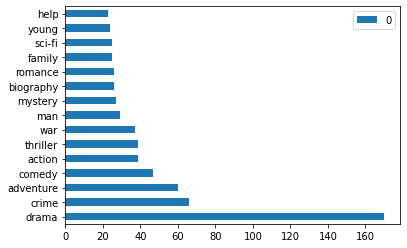

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

senlist=df['bag_of_words'].tolist()
wordlist=[]
for w in senlist:
  temp=w.split()
  for t in temp:
    wordlist.append(t)
counts = dict(Counter(wordlist).most_common(15))
df2 = pd.DataFrame.from_dict(counts, orient='index')
df2.plot.barh()